In [17]:
%run initplot.py
%load_ext autoreload
%autoreload 2
%matplotlib inline
import make_figures_great_again
import numpy as np
import matplotlib.pyplot as plt
from __future__ import unicode_literals

from matplotlib.ticker import MaxNLocator

from math import factorial
def bn(N,k):
    return float(factorial(N))/(factorial(k)*factorial(N-k))

from titlecase import titlecase
nicenames = {'evangelizer':'evangelizer','coolkids':'cool kids','snobs':'snobs','conformity2':'conformists','conformity3':'conformists'}
from __future__ import unicode_literals

legendkeys = {u'i-i->n':'I$\\rightarrow$I to I$\\rightarrow$S',
              u'i-n->i':'I$\\rightarrow$S to I$\\rightarrow$I',
              u'n-i->n':'S$\\rightarrow$I to S$\\rightarrow$S',
              u'n-n->i':'S$\\rightarrow$S to S$\\rightarrow$I',
             }
rewire_types = ['i-i->n','n-i->n','i-n->i','n-n->i',]
allmodels = ['evangelizer','coolkids','snobs']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from ode import *

In [19]:
#E = 50000.
try:
    del N
except NameError:
    pass
try:
    del E
except NameError:
    pass
try:
    del initI
except NameError:
    pass
try:
    del beta
except NameError:
    pass
num_integration_points=2000
max_steps = {'evangelizer':5000, 'coolkids':5000,'snobs':8000}
#samemax = 10000
#max_steps = {'evangelizer':samemax, 'coolkids':samemax,'snobs':samemax}
if False:
    N = 1000.     # number of people
    E = 5*N         # number of edges
    initI = .1 # 1e-2  # initial fraction infected

    #finalT = 20000
    #timepoints = np.exp(np.linspace(0, np.log(finalT+1), 2000))-1
    beta  = 3e-4
elif True:
    N = 1000.
    E = 2*N
    initI = .05
    #beta  = 8e-4
    beta  = 5e-4

elif True:
    N = 1000.
    E = 2*N
    initI = .05
    beta  = 1e-5
    max_steps = {'evangelizer':500000, 'coolkids':55000,'snobs':20000}
    
else:
    N = 10000.
    E = 5*N
    initI = .05
    beta  = 3e-4    
savefig = False
k=float(E)/float(N)
y0=np.array([initI, k*2*(1.-initI)*initI, k*initI**2, 0, 0, 0, 0])

(100, 7)
evangelizer [ 0.00060697  0.          0.          0.02392534]
(100, 7)
coolkids [ 0.          0.          0.00132699  0.02392554]
(100, 7)
snobs [ 0.          0.01303751  0.00217671  0.00023237]


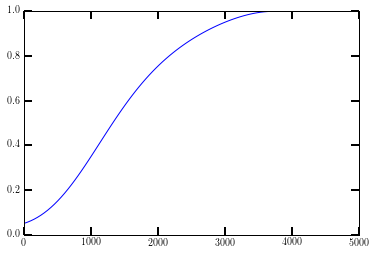

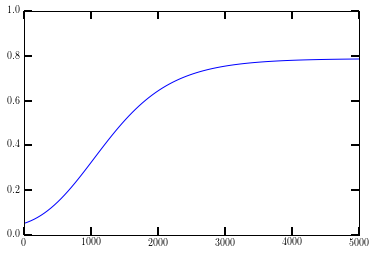

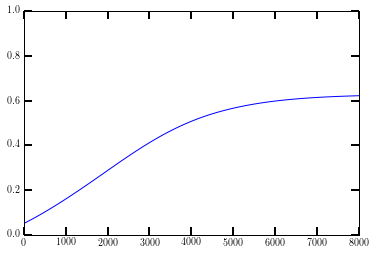

In [23]:
rdicts = {}
#beta = 1
for cmodel in allmodels:
    timepoints = np.linspace(0, max_steps[cmodel], 100)   # time steps

    traj = integrate(y0, timepoints, args=(beta, cmodel, N, E))
    print traj.shape
    #traj = odeint(derivs, y0, timepoints, args=(beta, cmodel, N, E))
    if False:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(timepoints, traj)
        plt.legend(['I', 'SI', 'II'])
        plt.xlabel('Time')
        plt.ylim([0,1])
        plt.subplot(1,2,2)
        plt.plot(timepoints[:-1], np.diff(traj,axis=0))
        plt.legend(['dI', 'dSI', 'dII'])
        plt.xlabel('Time')

    if True:
        plt.figure()
        plt.plot(timepoints, traj[:,0])
        #print traj.shape
        #print  traj[:,0]
        plt.ylim([0,1])

        rdicts[cmodel]= traj
        #{ 'num_infected' : traj[:,0] ,
        #                  'rewire_counts_list': np.diff(traj,axis=0)[:,-4:],
        #                  'rewire_types': ['i-i->n','n-i->n','i-n->i','n-n->i',]
        #                }
        print cmodel,  np.diff(traj,axis=0)[:,-4:][0,:]

0 evangelizer
1 coolkids
2 snobs
saving out/socialmodel-1stfig-v3.pdf


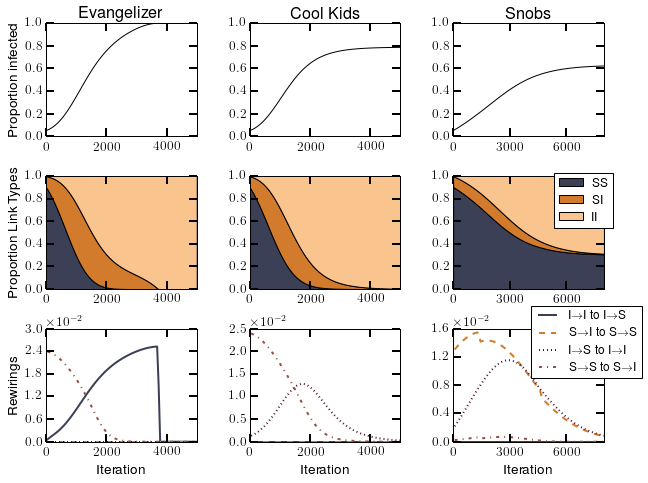

In [44]:

plt.rcParams['font.size']         = 34*.4

#mx_init, is_infected_init = inits[cnet]['mx_init'], inits[cnet]['is_infected_init']
#is_infected_init
#rdicts = rdicts_db[cnet]
ncols = 5

#plotitems = rdicts.keys()
plotitems = allmodels
ndicts = len(plotitems)
f, axmx = plt.subplots(3, 3, figsize=(10,2.5*ndicts)) # , sharex='col', sharey='row')
f.subplots_adjust(hspace=.35, wspace=.35)

axmx =axmx.T
for ndx, axrow in enumerate(axmx):
    cmodel = plotitems[ndx]
    timepoints = np.linspace(0, max_steps[cmodel], 100)   # time steps
    num_inf_ax, conn_types_ax, rewiring_ax = axrow
    if cmodel not in rdicts:
        continue
    rdict = rdicts[cmodel]
    colndx = 1
    print ndx, cmodel

    plt.sca(num_inf_ax)
    plt.plot(timepoints, np.array(rdict[:,0]),color='k')
    plt.title(titlecase(nicenames[cmodel]))
    if ndx == 0: 
        plt.ylabel('Proportion infected')
    #plt.xlabel('Iteration')
    plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 3) )
    #plt.locator_params(nbins=4,axis='x')

    plt.ylim([0, 1])
    plt.xlim([np.min(timepoints), np.max(timepoints)])
    # plt.plot(rdict['assortativity']);plt.title('%s - inf assortativity'%t)
    
    ax=plt.sca(conn_types_ax)
    SIprop, IIprop = rdict[:,1]/k, rdict[:,2]/k
    SSprop = 1.-(SIprop+IIprop)
    #print SI, II, SS
    #asdf

    terrific_colors = make_figures_great_again.the_best_colors.i_love_hispanics_6.mpl_colors

    plt.stackplot(timepoints, np.row_stack((SSprop,SIprop,IIprop)), colors=terrific_colors)
    plt.ylim([0, 1])
    plt.xlim([np.min(timepoints), np.max(timepoints)])
        
    if ndx == 2:
        #legend = plt.legend([r'$s \leftrightarrow s$',r'$s \leftrightarrow i$',r'$i \leftrightarrow i$'], bbox_to_anchor=(1.1,.58), fontsize=12)
        legend = plt.legend(['SS','SI','II'], bbox_to_anchor=(1.1,1.08), fontsize=12)

    from matplotlib.ticker import MaxNLocator
    plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 3) )

    if ndx == 0: 
        plt.ylabel('Proportion Link Types')
        
    plt.sca(rewiring_ax)
    #rws = np.array(rdict['rewire_counts_list'])
    rwsndx, rwtypes = zip(*[(i, rt) for i, rt in enumerate(rewire_types) if rt[-4:]!='none'])
    ##plotrws = rws[:,list(rwsndx)]
    #plotrws = rws

    #rewiring_ax.set_color_cycle(terrific_colors)
    rwrates = np.diff(rdict[:,3:], axis=0)
    #rwrates[np.isnan(rwrates)]=0.
                      
        
    from cycler import cycler
    #plt.rc('lines', linewidth=4)
    #plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) +
    #                           cycler('linestyle', ['-', '--', ':', '-.'])))
    #fig, (ax0, ax1) = plt.subplots(nrows=2)
    #ax0.plot(yy)
    #ax0.set_title('Set default color cycle to rgby')
    plt.gca().set_prop_cycle(cycler('color',np.array(terrific_colors)[[0,1,3,4],:])+cycler('linestyle', ['-', '--', ':', '-.'])) # cycler('color', ['c', 'm', 'y', 'k']) +
    #                   cycler('linestyle', ['-', '--', ':', '-.']))

    plt.plot(timepoints[1:], rwrates, lw=2)
    
    plt.xlabel('Iteration')
    plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 3) )
    #plt.ylim([0,3e-3])
    if ndx == 0: 
        plt.ylabel('Rewirings')
    
    #rewiring_ax.get_yaxis().get_major_formatter().set_scientific(True)

    #from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0, 1))
    plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 5) )
    
    #rewiring_ax.ticklabel_format(style = 'sci', useOffset=False)

    #plt.ylim([0, plt.ylim()[1]*1.1])
    if ndx == 2:
        #labels = [str(int(item)) if ndx <1 else '' for ndx, item in enumerate(plt.gca().get_xticks())]
        #plt.gca().set_xticklabels(labels)
        #print rwtypes
        #asdf
        legend = plt.legend([legendkeys.get(rwt, rwt) for rwt in rwtypes], bbox_to_anchor=(1.29,1.25), fontsize=12)
        legend.get_frame().set_facecolor('white')
        
fname='out/socialmodel-1stfig-v3.pdf' # %cnet
#if savefig:
print 'saving', fname
plt.savefig(fname, facecolor='white')
    

In [14]:
from ode import integratefinal
finalrates = {}
betavals = 10.**np.linspace(-5, -1, 40)
print betavals


#timepoints2 = np.linspace(0, 20000, 10000)   # time steps
for cmodel in allmodels:
    
    r = []
    for cbeta in betavals:
        cmaxsteps = max_steps[cmodel] * max(1e-2 / cbeta, 1) * 5
        print cmodel, cbeta, cmaxsteps
        timepoints2 = np.linspace(0, cmaxsteps, 100)#num_integration_points)   # time steps
        #traj = odeint(derivs,y0, timepoints2, args=(cbeta, cmodel, N, E))
        #traj = integrate(y0, timepoints2, args=(cbeta, cmodel, N, E))
        finalstate = integratefinal(y0, cmaxsteps, args=(cbeta, cmodel, N, E))
        #f = np.nansum(np.diff(traj, axis=0), axis=0)
        r.append(finalstate)
    finalrates[cmodel] = np.array(r)
         

[  1.00000000e-05   1.26638017e-05   1.60371874e-05   2.03091762e-05
   2.57191381e-05   3.25702066e-05   4.12462638e-05   5.22334507e-05
   6.61474064e-05   8.37677640e-05   1.06081836e-04   1.34339933e-04
   1.70125428e-04   2.15443469e-04   2.72833338e-04   3.45510729e-04
   4.37547938e-04   5.54102033e-04   7.01703829e-04   8.88623816e-04
   1.12533558e-03   1.42510267e-03   1.80472177e-03   2.28546386e-03
   2.89426612e-03   3.66524124e-03   4.64158883e-03   5.87801607e-03
   7.44380301e-03   9.42668455e-03   1.19377664e-02   1.51177507e-02
   1.91448198e-02   2.42446202e-02   3.07029063e-02   3.88815518e-02
   4.92388263e-02   6.23550734e-02   7.89652287e-02   1.00000000e-01]
evangelizer 1e-05 25000000.0
evangelizer 1.26638017347e-05 19741307.1712
evangelizer 1.60371874375e-05 15588768.3532
evangelizer 2.0309176209e-05 12309706.5793
evangelizer 2.57191380906e-05 9720387.95077
evangelizer 3.25702065566e-05 7675726.57439
evangelizer 4.1246263829e-05 6061155.04271
evangelizer 5.2233

Saving out/socialmodel-betasweep-v2.pdf


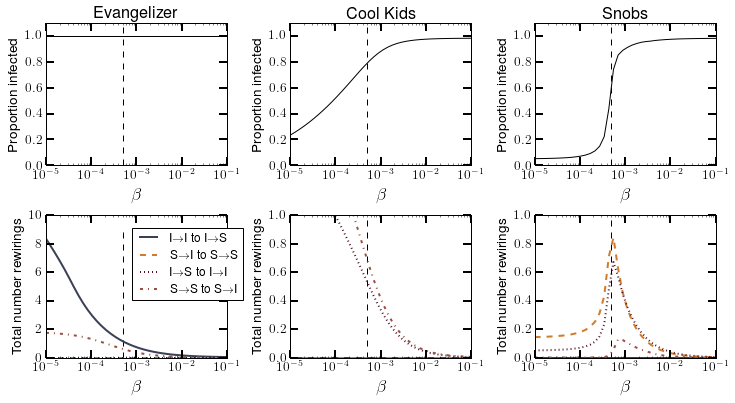

In [47]:
f, axmx = plt.subplots(2, 3, figsize=(12,6)) # , sharex='col', sharey='row')
f.subplots_adjust(hspace=.35, wspace=.35)
#plt.figure(figsize=(9*4,6*4))
for tndx, cmodel in enumerate(allmodels):
    if cmodel not in finalrates:
        continue
    plt.sca(axmx[0,tndx])
    plt.semilogx(betavals, finalrates[ cmodel ][:,0], color='k')
    plt.ylim([0,1.1])
    
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.ylabel('Proportion infected')
    plt.vlines(beta, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    plt.title(titlecase(nicenames[cmodel]))
    
    plt.sca(axmx[1,tndx])
    plt.gca().set_prop_cycle(cycler('color',np.array(terrific_colors)[[0,1,3,4],:])+cycler('linestyle', ['-', '--', ':', '-.'])) # cycler('color', ['c', 'm', 'y', 'k']) +
    
    plt.semilogx(betavals, finalrates[ cmodel ][:,-4:], lw=2)
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 5) )
    if tndx in [1,2]:
        plt.ylim([0,1])
        
    plt.vlines(beta, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    #plt.subplot(3,2,tndx*2+2)
    #plt.sca(axmx[1,tndx])
    #all_rwts = [ 'i-i->n', 'n-i->n', 'i-n->i',  'n-n->i']
    """
    for rwt in all_rwts:
        clist = []

        for i in range(len(d)):
            ix = [ndx for ndx, c in enumerate(d[i][1]['rewire_types']) if c == rwt][0]
            clist.append((d[i][0], np.array(d[i][1]['rewire_counts_list'])[-1,ix]))
        ps, data = zip(*clist) 
        plt.semilogx(ps, data)
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.ylabel('Total number rewirings')
    plt.vlines(0.0002, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    """
    plt.ylabel('Total number rewirings')
    
    if tndx == 0:
        rwsndx, rwtypes = zip(*[(i, rt) for i, rt in enumerate(rewire_types) if rt[-4:]!='none'])
        legend = plt.legend([legendkeys.get(rwt, rwt) for rwt in rwtypes], bbox_to_anchor=(1.12,0.95), fontsize=12)
        legend.get_frame().set_facecolor('white')
        
fname = 'out/socialmodel-betasweep-v2.pdf'
print "Saving", fname
plt.savefig(fname, bbox_inches='tight',facecolor='white')
    

In [ ]:
finalrates[ 'evangelizer' ][:,0]

In [ ]:
    
    #plt.figure()
    #print finalrates[cmodel]
    plt.sca(axmx[0,tndx])
    plt.semilogx(betavals, finalrates[ cmodel ][:,0], color='k')
    #continue
    plt.sca(axmx[1,tndx])
    #all_rwts = [ 'i-i->n', 'n-i->n', 'i-n->i',  'n-n->i']
    plt.semilogx(betavals, finalrates[ cmodel ][:,-4:])
    continue
    for rwtndx, rwt in enumerate(rewire_types):
        #clist = []
        #
        #for i in range(len(d)):
        #    ix = [ndx for ndx, c in enumerate(d[i][1]['rewire_types']) if c == rwt][0]
        #    clist.append((d[i][0], np.array(d[i][1]['rewire_counts_list'])[-1,ix]))
        #ps, data = zip(*clist) 
        #print finalrates[ cmodel ][:,4+rwtndx]
        plt.semilogx(betavals, finalrates[ cmodel ][:,-4:])
    
    continue
    ps, numinfs = zip(*[(betavals, finalrates[ cmodel ]) for i in range(len(d))])
    #plt.subplot(3,2,tndx*2+1)
    plt.sca(axmx[0,tndx])
    plt.semilogx(ps, np.array(numinfs)/float(N), color='k')
    plt.ylim([0, 1.05*plt.ylim()[1]])
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.ylabel('Proportion infected')
    plt.vlines(0.0002, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    plt.title(titlecase(nicenames[cmodel]))
    #plt.subplot(3,2,tndx*2+2)
    plt.sca(axmx[1,tndx])
    all_rwts = [ 'i-i->n', 'n-i->n', 'i-n->i',  'n-n->i']
    for rwt in all_rwts:
        clist = []

        for i in range(len(d)):
            ix = [ndx for ndx, c in enumerate(d[i][1]['rewire_types']) if c == rwt][0]
            clist.append((d[i][0], np.array(d[i][1]['rewire_counts_list'])[-1,ix]))
        ps, data = zip(*clist) 
        plt.semilogx(ps, data)
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.ylabel('Total number rewirings')
    plt.vlines(0.0002, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    if tndx == 0:
        legend = plt.legend([legendkeys.get(rwt, rwt) for rwt in all_rwts], bbox_to_anchor=(1.06,1), fontsize=12)
        legend.get_frame().set_facecolor('white')

#plt.savefig('out/ptransmit_sweep_v2.pdf', bbox_inches='tight',facecolor='white')

In [ ]:
plt.semilogx(betavals, finalrates[ cmodel ][:,4])
    